# Redes Sociais - APS 2

### Alunos: Arthur Barreto, Enricco Gemha e Felipe Catapano


Uma rede de artistas do Spotify que se conectam através de participar em determinada música, que foi topo das paradas em alguma semana no mundo, durante o período de 28/09/2013 a 09/10/2022. Os vértices representam artistas do Spotify e uma aresta não-direcionada indica uma música feita em parceria por dois artistas.

_Nota: os grafos são não-dirigidos, conforme informado no agregador de databases [Kaggle](https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network), do qual foi extraído a base utilizada aqui._

## Pré-requisitos

In [1]:
import graph_tool_extras as gte
import netpixi
from graph_tool import draw
import distribution as dst

In [2]:
PATH = 'edges.csv'
PATH_NOS = 'nodes.csv'

## Análise dos dados importados

O arquivo relevante à análise inicial é `edges.csv`, que representa uma lista de valores separados por _vírgulas_, com uma aresta por linha. O significado de cada coluna do arquivo é:

- Primeira coluna: ID do nó de participação em música
- Segunda coluna: ID do nó de participação em música

In [3]:
with open(PATH) as file:

    # cria index de contagem para o loop abaixo.
    i = 0
    
    # ignora o cabeçalho.
    next(file)

    # Para não sobrecarregar este notebook
    # vamos espiar somente as 5 primeiras linhas.
    for line in file:

        # Transforma a linha em uma lista de partes,
        # considerando a vírgula como separador.
        parts = line.split(',')
        no1 = parts[0]
        no2 = parts[1].replace('\n', '')

        print(f'{no1} - {no2}')
        
        # Para não sobrecarregar este notebook, vamos usar um contador
        # e um break para imprimir apenas as cinco primeiras linhas.
        i += 1
        if i == 5:
            break

76M2Ekj8bG8W7X2nbx2CpF - 7sfl4Xt5KmfyDs2T3SVSMK
0hk4xVujcyOr6USD95wcWb - 7Do8se3ZoaVqUt3woqqSrD
38jpuy3yt3QIxQ8Fn1HTeJ - 4csQIMQm6vI2A2SCVDuM2z
6PvcxssrQ0QaJVaBWHD07l - 6UCQYrcJ6wab6gnQ89OJFh
2R1QrQqWuw3IjoP5dXRFjt - 4mk1ScvOUkuQzzCZpT6bc0


## Criação do grafo

Utilizaremos a biblioteca [graph-tool](https://graph-tool.skewed.de/) somente para criação e visualização básica dos grafos, sem suporte de nenhum método ou função que não seja essencial.

In [4]:
g = gte.Graph(directed=False) # pois o grafo não é direcionado, como informado acima.

Antes, vamos definir duas funções auxiliares para facilitar a adição de novos nós e arestas, respectivamente.

In [5]:
def get_or_add_vertex(g, id):
    u = g.vertex_by_id(id)
    if u is None:
        u = g.add_vertex_by_id(id)
    return u

def get_or_add_edge(g, id1, id2):
    e = g.edge_by_ids(id1, id2)
    if e is None:
        e = g.add_edge_by_ids(id1, id2)
    return e

Depois de criar o novo grafo, vamos armazenar os valores de `edges.csv` nele, o transformando em uma rede.

In [6]:
with open(PATH) as file:

    # Cria index de contagem de linhas lidas.
    i = 1
    
    # Ignora o cabeçalho.
    next(file)

    # Itera linha a linha do arquivo `out.linux`
    for line in file:

        # Transforma a linha em uma lista de partes,
        # considerando a vírgula como separador.
        parts = line.split(',')

        # Define os IDs de origem e destino.
        no1 = parts[0]
        no2 = parts[1].replace('\n', '')

        # Adiciona os vértices.
        get_or_add_vertex(g, no1)
        get_or_add_vertex(g, no2)
    
        # Adiciona a aresta correspondente a esta linha.
        get_or_add_edge(g, no1, no2)
        
        # Incrementa o contador de linhas lidas.
        i += 1

# Imprime a quantidade de linhas lidas.
print(f'Foram lidas {i} linhas.') 

Foram lidas 300387 linhas.


A seguir, devemos chamar `draw.sfdp_layout`, passando a rede, para rodar um algoritmo de posicionamento chamado SFDP [[1](#sfdp)].

Esse algoritmo usa uma ideia conhecida como [force-directed graph drawing](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) para posicionar os vértices de forma a evidenciar agrupamentos.

In [7]:
layout = draw.sfdp_layout(g)

In [8]:
gte.move(g, layout)

## Armazenamento da rede

Para garantir a segurança da informação processada, devemos guardá-la em um arquivo na mesma pasta deste notebook.

In [9]:
g = gte.clean(g)
gte.save(g, 'spotify.net.gz')

## Visualização da rede

O próximo passo é a renderização da rede.

In [10]:
r = netpixi.render('spotify.net.gz', infinite=True)

Por fim, devemos ajustar a visualização da renderização.

In [11]:
r.vertex_default(size=4, bwidth=1)

In [12]:
r.edge_default(width=1)

## Estatísticas

Abaixo é possível ver o tamanho da rede, ou seja, a quantidade de _nodes_ e _edges_.

In [13]:
print(f"Número de nós: {len(g.get_vertices())}")
print(f"Número de arestas: {len(g.get_edges())}")

Número de nós: 148386
Número de arestas: 296770


A densidade da rede é a razão do número de pares conectados (dentre todos os pares), enquanto a transitividade aponta a razão de trios de nós que estão conectados (dentre todos os trios), na forma de triângulos.

In [14]:
print(f"Densidade da rede: {g.density()}")
print(f"Transitividade da rede: {g.transitivity()}")

Densidade da rede: 0.0
Transitividade da rede: 3.84


In [15]:
degrees = g.get_total_degrees() # obtem a quantidade de vizinhos dos vértices

In [16]:
degrees.describe() # por ser uma série do Pandas, utilizamos o método describe()

count    148386.000000
mean          3.999973
std          14.678956
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1781.000000
dtype: float64

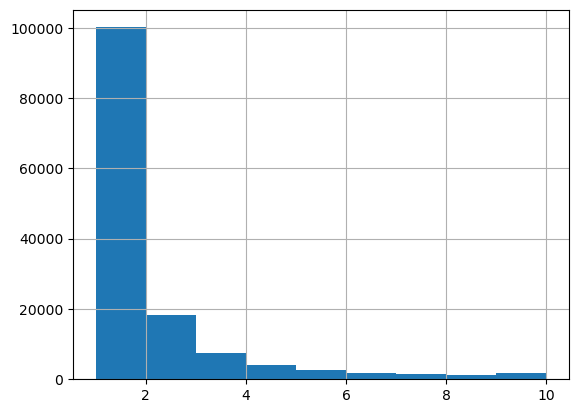

In [19]:
import numpy as np
degrees.hist(bins = np.arange(1,11,1));

In [20]:
dst.not_normal(degrees)

0.0

In [21]:
dst.more_powerlaw_than_lognormal(degrees)

Calculating best minimal value for power law fit


/usr/local/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


(False, 0.18293662318438697)

In [22]:
dst.more_powerlaw_than_exponential(degrees)

Calculating best minimal value for power law fit


(True, 0.013424324173432181)

### Estratificando a amostra pelo número de nós

Devido ao fato do método distance ser $O(n^2)$ é necessário estratificar para que o algoritmo consiga rodar (já que não há memória RAM suficiente disponível).

In [23]:
dict_nos = {}

with open(PATH_NOS) as file:

    # cria index de contagem para o loop abaixo.
    i = 0
    
    # ignora o cabeçalho.
    next(file)

    # Para não sobrecarregar este notebook
    # vamos espiar somente as 5 primeiras linhas.
    for line in file:

        # Transforma a linha em uma lista de partes,
        # considerando a vírgula como separador.
        parts = line.split(',')

        id = parts[0]

        if id not in dict_nos:
            dict_nos[id] = i
            i += 1

print(f'Contamos {i} nós!')
print(f'O dicionário tem {len(list(dict_nos.keys()))} chaves')

Contamos 156320 nós!
O dicionário tem 156320 chaves


Visualizando os valores do dicionário:

In [24]:
list(dict_nos.keys())[:5]

['48WvrUGoijadXXCsGocwM4',
 '4lDiJcOJ2GLCK6p9q5BgfK',
 '652XIvIBNGg3C0KIGEJWit',
 '3dXC1YPbnQPsfHPVkm1ipj',
 '74terC9ol9zMo8rfzhSOiG']

In [25]:
list(dict_nos.values())[:5]

[0, 1, 2, 3, 4]

A abordagem será sortear indices, que variam de 1 até a quantidade de nós `i`. Após isso, basta verificar os índices sorteados que estão na lista de valores do dicionário criado.

Selecionamos, portanto, 10.000 nós aleatórios, para que não estouremos a quantidade limite em memória RAM.

In [26]:
import numpy as np
from numpy.random import choice

lisIdx = np.arange(1, i + 1, 1)
lisProb = np.ones(shape=len(lisIdx), dtype=lisIdx.dtype)
lisProb = np.divide(lisProb, len(lisProb))
idxSort = choice(lisIdx, int(10e3), p = lisProb, replace = False)
idxSort.sort()
idxSort[:5]

array([37, 46, 48, 65, 78])

Para facilitar a verificação dos nos considerados, basta inverter o dicionário, desta forma, as chaves serão os índices e os valores os nós em si.

In [27]:
idx_no = {v: k for k, v in dict_nos.items()}

In [28]:
list(idx_no.keys())[:5], list(idx_no.values())[:5]

([0, 1, 2, 3, 4],
 ['48WvrUGoijadXXCsGocwM4',
  '4lDiJcOJ2GLCK6p9q5BgfK',
  '652XIvIBNGg3C0KIGEJWit',
  '3dXC1YPbnQPsfHPVkm1ipj',
  '74terC9ol9zMo8rfzhSOiG'])

In [29]:
noStrat = {idx_no[idx]: idx for idx in idxSort}

In [30]:
list(noStrat.values())[:5]

[37, 46, 48, 65, 78]

### Criando um novo grafo `g_strat`

Realizamos abaixo o mesmo procedimento que foi aplicado ao grafo principal `g`, com a diferença de que agora estaremos utilizando somente os nós estratificados, salvando em `g_strat`.

In [31]:
g_strat = gte.Graph(directed=False) # pois o grafo não é direcionado, como informado acima.

In [32]:
with open(PATH) as file:

    # Cria index de contagem de linhas lidas.
    i = 1
    j = 0
    
    # Ignora o cabeçalho.
    next(file)

    # Itera linha a linha do arquivo
    for line in file:

        # Transforma a linha em uma lista de partes,
        # considerando a vírgula como separador.
        parts = line.split(',')

        # Define os IDs de origem e destino.
        no1 = parts[0]
        no2 = parts[1].replace('\n', '')

        if (no1 and no2) in noStrat:
            # Adiciona os vértices somente para os nós estratificados.
            get_or_add_vertex(g_strat, no1)
            get_or_add_vertex(g_strat, no2)
    
            # Adiciona a aresta correspondente a esta linha.
            get_or_add_edge(g_strat, no1, no2)

            j += 1
        
        # Incrementa o contador de linhas lidas.
        i += 1

# Imprime a quantidade de linhas lidas.
print(f'Foram lidas {i} linhas.') 
print(f'Foram considerados {j} arestas')

Foram lidas 300387 linhas.
Foram considerados 20105 arestas


In [33]:
layout_strat = draw.sfdp_layout(g_strat)

In [34]:
gte.move(g_strat, layout_strat)

In [35]:
g_strat = gte.clean(g_strat)
gte.save(g_strat, 'spotify_strat.net.gz')

### Obtendo a Distribuição de Distância

In [39]:
distances = g_strat.get_distances()

In [40]:
distances.describe()

count    1.767304e+08
mean     8.187717e+00
std      2.667700e+00
min      0.000000e+00
25%      6.000000e+00
50%      8.000000e+00
75%      1.000000e+01
max      2.800000e+01
dtype: float64

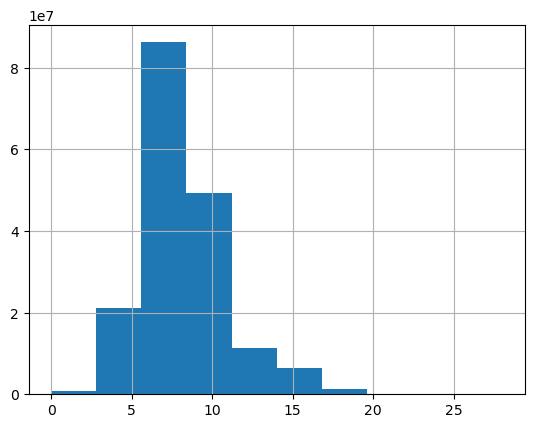

In [41]:
distances.hist();